## Simulation code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from tqdm import tqdm

__location__ = os.path.realpath(os.getcwd())

__location__ += "\\Desktop\\Capstone"

class DBM_RDG:

    def __init__(self,
                 N = 40,
                 dimensions=None,
                 nu=1.5,
                 debug=False,
                 threshold = 0.0001):

        # Unless specified, expect grid of NxNxN dimension, in order z, x, y
        if dimensions is None:
            self.dim = {'width': N, 'depth': N,'height': N}
        else:
            self.dim = {'width': dimensions[0], 'depth': dimensions[1],'height': dimensions[2]}

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  anything else encodes fixed potential
        # (I also use this grid to track order of cells in lightning structure)
        self.fixed_grid = np.zeros(shape=list(self.dim.values()))
        
        # Set all boundaries to be fixed
        self.fixed_grid[:, :, 0] = -1  # front boundary
        self.fixed_grid[:, :, -1] = -1  # back boundary
        self.fixed_grid[:, 0, :] = -1  # left boundary
        self.fixed_grid[:, -1, :] = -1  # right boundary
        self.fixed_grid[0, :, :] = -1  # top boundary
        self.fixed_grid[-1, :, :] = -1  # bottom boundary

        # The electric potential
        self.potential = np.zeros(shape=list(self.dim.values()))

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 1

        # To debug or not
        self.debug = debug

        # Keep track of current neighbors of structure
        self.structure_neighbors = set()

        self.struck_ground = False

        self.threshold = threshold

        # Debugging lists
        self.difference_per_conv = []
        self.overall_sum = []
        
        self.structure_history = []
        
        self.dist_to_ground = self.dim['height']

        # odd neighbors
        self.odd_neighbors = [(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), (0, 0, 1), (0, 0, -1),  
                          (0, 1, 1), 
                          (0, 1, -1), 
                          (1, 1, 1), 
                          (1, 1, -1), 
                          (1, 0, -1), 
                          (1, 0, 1) 
                         ]
        
        
        # Even neighbors
        self.even_neighbors = [(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), (0, 0, 1), (0, 0, -1),  
                          (0, -1, 1), 
                          (0, -1, -1), 
                          (-1, -1, 1), 
                          (-1, -1, -1),
                          (-1, 0, -1),
                          (-1, 0, 1) 
                         ]
        
        # Setup initial electric potential
        self.initial_electric_pot()

        # Add the first cell as a structure neighbor
        self.structure_neighbors.add((self.dim['width']//2, self.dim['depth']//2, 0))

        # Update structure with that cell
        self.expand_lightning_to((self.dim['width']//2, self.dim['depth']//2, 0))

        
        self.steps += 1
               
    # Could remove this
    def get_neighbors(self, pos):
        '''Returns the set of neighbors given cell position'''
        
        neighbors = []
        
        # Cell neighbors list alternate each layer in z-axis
        if pos[2] % 2 == 0:
            for neighbor_rel in self.even_neighbors:
                neighbors.append((pos[0]+neighbor_rel[0], pos[1]+neighbor_rel[1], pos[2]+neighbor_rel[2]))
        else:
            for neighbor_rel in self.odd_neighbors:
                neighbors.append((pos[0]+neighbor_rel[0], pos[1]+neighbor_rel[1], pos[2]+neighbor_rel[2]))

        return neighbors


    def strike_lightning(self):
        '''Run simulation until structures strikes ground'''

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.dim['height'], desc="How close the lightning is to the ground", unit="iter")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.dim['height'] - self.newest_neighbor[2] < self.dist_to_ground:
                    self.dist_to_ground = self.dim['height'] - self.newest_neighbor[2]
                    progress_bar.update(1)

    def update(self):
        '''Choose structure neighbor to expand into, update electric potential'''

        weights = []
        # For each structure neighbor
        for neighbor_pos in self.structure_neighbors:
            # Raise each weight to the power of nu
            weights.append(self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] ** self.nu)
        
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(self.structure_neighbors), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.expand_lightning_to(chosen_cell)

        self.steps += 1

    def initial_electric_pot(self):
        # Create a linear gradient along the depth axis
        gradient = np.linspace(0, 1, self.dim['height'])[np.newaxis, np.newaxis, :]
        #gradient = np.linspace(0, 0, self.dim['width'])[:, np.newaxis, np.newaxis]

        # Apply the gradient to the array
        self.potential += gradient


    def expand_lightning_to(self, pos):
        '''
        Updates correpsonding grids
        Update neighborhood of lightning structure
        Call method to update electric potential
        '''

        self.newest_neighbor = pos
        
        self.structure_history.append(pos)

        # Remove the potential
        self.potential[pos[0], pos[1], pos[2]] = 0
        #self.potential[pos[0], pos[1], pos[2]] = 1

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1], pos[2]] = self.steps

        # Update structure neighbors
        self.structure_neighbors.remove(pos)
        for neighbor_pos in self.get_neighbors(pos):
            if neighbor_pos[2] == self.dim['height']:
                self.struck_ground = True
                break

            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.dim['width'] and \
                neighbor_pos[1] >= 0 and neighbor_pos[1] < self.dim['depth'] and \
                neighbor_pos[2] >= 0 and neighbor_pos[2] < self.dim['height'] and \
                self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] != 0:
                    self.structure_neighbors.add(neighbor_pos)

        if not self.struck_ground:
            # Update the rest of the potential
            self.potential = self.update_electric_potential()


    def update_electric_potential(self):
        '''
        Uses iterative diffusion to estimate solution to Laplace equation.
        Tracks percentual change for each cell after each diffusion, 
        terminates when the largest percentual change is less than threshold
        '''

        # Make ground and lightning structure fixed
        no_change_mask = self.fixed_grid != 0


        old_potential = np.copy(self.potential)
        new_potential = np.copy(old_potential)

        itr = 0
        # Until threshold is hit, keep updating electric potential
        while True:
            
            # Two arrays for the two types of neighborhoods
            neighbor_avgs_even_new = np.zeros_like(new_potential)
            neighbor_avgs_odd_new = np.zeros_like(new_potential)
            
            # Perform diffusion globally using both neighbors
            for neighbor in self.odd_neighbors:
                neighbor_avgs_odd_new += np.roll(new_potential, neighbor, axis=(0,1,2))
                
            for neighbor in self.even_neighbors:
                neighbor_avgs_even_new += np.roll(new_potential, neighbor, axis=(0,1,2))
                
            # Set odd z-axis layers to 0
            neighbor_avgs_odd_new[:,:,1::2] = 0
            # Set even z-axis layers to 0
            neighbor_avgs_even_new[:,:,::2] = 0
            
            # Merge them
            neighbor_avgs_new = (neighbor_avgs_even_new + neighbor_avgs_odd_new) / len(self.even_neighbors)
        
            new_potential = neighbor_avgs_new
        
            # Reset the cells that shouldn't change
            new_potential[no_change_mask] = self.potential[no_change_mask]
        
            if self.debug:
                self.difference_per_conv.append(np.sum(abs(np.array(new_potential) - np.array(old_potential))))
                self.overall_sum.append(np.sum(np.array(new_potential)))
            
            # percentual change relative to previous iteration
            rel_differences = np.divide(abs(np.array(new_potential) - np.array(old_potential)),np.array(old_potential), out=np.zeros(old_potential.shape, dtype=float), where=old_potential!=0)

            # Terminate when max percentual change is small (below threshold)
            if np.nanmax(rel_differences) < self.threshold:
                break

            old_potential = np.copy(new_potential)
            
        return new_potential

### Analyse time to run

In [3]:
import cProfile
width=20
height=20
nu=6
threshold=0.001
sim_instance = DBM_RDG(dimensions=(width, width, height), nu=nu, threshold=threshold)
cProfile.run("sim_instance.strike_lightning()")

         169548 function calls in 0.676 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.672    0.672 972638478.py:113(strike_lightning)
       28    0.007    0.000    0.672    0.024 972638478.py:133(update)
       28    0.001    0.000    0.665    0.024 972638478.py:159(expand_lightning_to)
       27    0.178    0.007    0.664    0.025 972638478.py:195(update_electric_potential)
       28    0.000    0.000    0.000    0.000 972638478.py:97(get_neighbors)
        1    0.000    0.000    0.672    0.672 <string>:1(<module>)
      717    0.000    0.000    0.000    0.000 _function_base_impl.py:894(_copy_dispatcher)
      717    0.000    0.000    0.005    0.000 _function_base_impl.py:898(copy)
      690    0.001    0.000    0.004    0.000 _methods.py:58(_any)
      690    0.000    0.000    0.000    0.000 _nanfunctions_impl.py:378(_nanmax_dispatcher)
      690    0.005    0.000    0.018    0.000 _nan

## Gather data

In [ ]:
# --- Simulation parameters ---
target_height = 14
nu=6
threshold=0.001
target_height_is_in_cells = False
# -----------------------------
if target_height_is_in_cells:
    height_in_cells = target_height
    width_in_cells = round(target_height*2/np.sqrt(2))
    depth_in_cells = round(target_height*2/np.sqrt(2))
else:
    height_in_cells = round(target_height*np.sqrt(2))
    width_in_cells = target_height*2
    depth_in_cells = target_height*2
import os
print(width_in_cells, depth_in_cells, height_in_cells)

filename_viz =    f"{__location__}\\data\\RDG_square_int\\{width_in_cells}x{depth_in_cells}x{height_in_cells}_{nu}_{threshold}_vizdata.txt"
filename_strike = f"{__location__}\\data\\RDG_square_int\\{width_in_cells}x{depth_in_cells}x{height_in_cells}_{nu}_{threshold}_strikedata.txt"
filename_volume = f"{__location__}\\data\\RDG_square_int\\{width_in_cells}x{depth_in_cells}x{height_in_cells}_{nu}_{threshold}_volumedata.txt"
viz_file = open(filename_viz,'a')
strike_file = open(filename_strike,'a')
volume_file = open(filename_volume,'a')

viz_storing_freq = 200

i = 0
while True:
    sim_instance = DBM_RDG(dimensions=(width_in_cells, depth_in_cells, height_in_cells), nu=nu, threshold=threshold)
    sim_instance.strike_lightning()

    i += 1

    if i % viz_storing_freq == 0:
        for pos in sim_instance.structure_history:
            viz_file.write(f"{pos}.")
        viz_file.write('#')
        print()

    strike_file.write(f"{sim_instance.newest_neighbor}#")
    volume_file.write(f"{len(sim_instance.structure_history)}#")
    
    print('*', end='')


28 28 20
*******************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************
***********************************************************************************************************************

In [6]:
viz_file.close()
strike_file.close()
volume_file.close()

## Strike location distribution

In [10]:
target_height = 20
nu=6
threshold=0.001
# -----------------------------
height_in_cells = int(target_height*np.sqrt(2))
width_in_cells = target_height*2
depth_in_cells = target_height*2


filename_strike = f"C:\\Users\\gabriel\\Desktop\\Capstone\\data\\RDG_square_int\\{width_in_cells}x{depth_in_cells}x{height_in_cells}_{nu}_{threshold}_strikedata.txt"
strike_file = open(filename_strike,'r')
strike_data_str = strike_file.read()
strike_data_str = strike_data_str.split('#')[:-1]

strike_data = np.zeros((width_in_cells, depth_in_cells))
print("Datapoints:",len(strike_data_str))

for point in strike_data_str:
    point = point.split(',')
    x_coord = point[0]
    y_coord = point[1]
    x_coord = x_coord.strip()
    x_coord = x_coord.strip('(')
    y_coord = y_coord.strip()
    y_coord = y_coord.strip(')')
    strike_data[int(x_coord), int(y_coord)] += 1

cmap = matplotlib.cm.viridis
fig = plt.figure(figsize=(8,6))
plt.imshow(strike_data, cmap=cmap)
plt.colorbar()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\gabriel\\Desktop\\Capstone\\data\\RDG_square_int\\40x40x28_6_0.001_strikedata.txt'

## Visualize lightning

In [1]:
# Load lightning visualization capabilities
%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import copy
from ipywidgets import *

def rhombic_dodecahedron_vertices():
    """Return the vertices of a rhombic dodecahedron centered at the origin."""
    vertices = np.array([
        [ 1,  1,  1], # 0
        [ 1,  1, -1], # 1
        [ 1, -1,  1], # 2
        [ 1, -1, -1], # 3
        [-1,  1,  1], # 4
        [-1,  1, -1], # 5
        [-1, -1,  1], # 6
        [-1, -1, -1], # 7
        [ 0,  0,  2], # 8
        [ 0,  0, -2], # 9
        [ 0,  2,  0], # 10
        [ 0, -2,  0], # 11
        [ 2,  0,  0], # 12
        [-2,  0,  0]  # 13
    ])
    return vertices / np.sqrt(2)

def rhombic_dodecahedron_faces():
    """Return the faces of a rhombic dodecahedron using vertex indices."""
    faces = [
        [0, 8, 2, 12], [6, 8, 4, 13], [0, 8, 4, 10], [2, 8, 6, 11], # top 4
        [0, 10, 1, 12], [2, 12, 3, 11], [6, 11, 7, 13], [4, 13, 5, 10], # middle 4
        [1, 9, 3, 12], [7, 9, 5, 13], [1, 9, 5, 10], [3, 9, 7, 11] # bottom 4
    ]
    return faces

def plot_rhombic_dodecahedron(ax, pos=(0,0,0), color='cyan', alpha=0.3, scale=1, line_thickness = 1):
    vertices = rhombic_dodecahedron_vertices()
    faces = rhombic_dodecahedron_faces()

    pos = np.array(pos)

    cartes_pos = copy.deepcopy(pos)
    cartes_pos[0] += pos[1]# - 1*pos[2]//2

    cartes_pos[1] -= pos[0]# + 1*(pos[2]//2)

    #if pos[2] % 2 == 1:
    cartes_pos[0] += pos[2]
        #color = 'orange'

    poly3d = [[(np.array(vertices[vertice])+np.array(cartes_pos)*np.sqrt(2))*scale for vertice in face] for face in faces]
    ax.add_collection3d(Poly3DCollection(poly3d, facecolors=color, linewidths=0.5*line_thickness, edgecolors='b', alpha=alpha))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-4, 4])


def plot_from_grid(pos_list, colors=[], alphas=[], scale=1, line_thickness=1):
    
    if len(colors) != len(pos_list):
        colors = ['orange'] * len(pos_list)
    if len(alphas) != len(pos_list):
        alphas = [0.1] * len(pos_list)
    
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, gridpos_to_plot_pos(pos), colors[i], alpha=alphas[i], scale=scale, line_thickness=line_thickness)

    #plt.axis('off')

    def update(tilt = 0.5, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);

def gridpos_to_plot_pos(pos):
    return (pos[0]-pos[2]//2, pos[1]-pos[2]//2, pos[2])


def plot_lightning_structure(this_RDG_instance):
    alphas = list(np.linspace(1, 0, len(this_RDG_instance.structure_history)))

    pos_list = []
    pos_list.extend([(pos[0] + pos[2] % 2, pos[1] + pos[2] % 2, this_RDG_instance.dim['height']-1-pos[2]) for pos in this_RDG_instance.structure_history])

    # Plot the edges of the boundary
    if False:
        for x in range(1, this_RDG_instance.dim['width']):
            pos_list.append((x, 0, 0)) 
            pos_list.append((x, this_RDG_instance.dim['depth'], 0)) 
            pos_list.append((x, 0, this_RDG_instance.dim['height']))
            pos_list.append((x, this_RDG_instance.dim['depth'], this_RDG_instance.dim['height']))
            for _ in range(4):
                alphas.append(0)

        for y in range(1, this_RDG_instance.dim['depth']):
            pos_list.append((0, y, 0)) 
            pos_list.append((this_RDG_instance.dim['width'], y, 0)) 
            pos_list.append((0, y, this_RDG_instance.dim['height']))
            pos_list.append((this_RDG_instance.dim['width'], y, this_RDG_instance.dim['height']))
            for _ in range(4):
                alphas.append(0)

        for z in range(1, this_RDG_instance.dim['height']):
            pos_list.append((0, 0, z))
            pos_list.append((this_RDG_instance.dim['width'], 0, z)) 
            pos_list.append((0, this_RDG_instance.dim['depth'], z))
            pos_list.append((this_RDG_instance.dim['width'], this_RDG_instance.dim['depth'], z))
            for _ in range(4):
                alphas.append(0)

    plot_from_grid(pos_list, alphas=alphas, scale=0.15, line_thickness=0.25)

if False: # Toggle this if you want to see examples of rhombic dodecahedron
    # Define the angles you want to view the plot from
    angles = [(30, 30), (45, 45), (60, 60), (75, 75)]

    # Create subplots for each angle
    fig = plt.figure(figsize=(10, 10))
    for i, angle in enumerate(angles):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        plot_rhombic_dodecahedron(ax)
        plot_rhombic_dodecahedron(ax,pos=(0,0,1))
        ax.view_init(elev=angle[0], azim=angle[1])
        ax.set_title(f'View (elev={angle[0]}, azim={angle[1]})')

    plt.show()

In [9]:
RDG_instance = DBM_RDG(dimensions=[30, 30, 30], nu=10, threshold=0.005)
RDG_instance.strike_lightning()

C:\Users\gabri\AppData\Local\Temp/ipykernel_8652/3269852316.py:315: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)


<IPython.core.display.Javascript object>


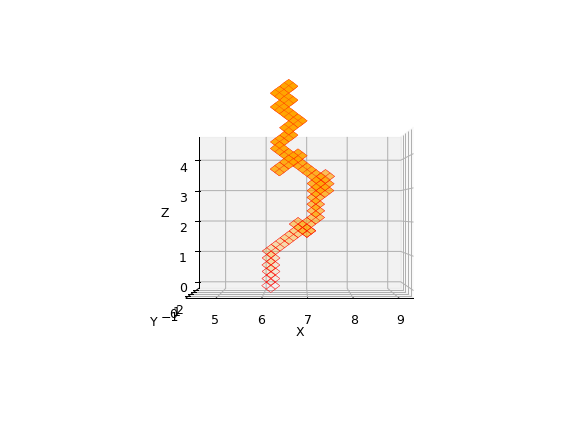

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [13]:
plot_lightning_structure(RDG_instance)

## Visualize electric potential, step by step

In [8]:
RDG_instance_pot = DBM_RDG(dimensions=[20, 20, 20], nu=10, threshold=0.005)

C:\Users\gabri\AppData\Local\Temp/ipykernel_7488/3269852316.py:315: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)


In [9]:
for i in range(1):
    RDG_instance_pot.strike_lightning()
    #RDG_instance_pot.update_electric_potential()

C:\Users\gabri\AppData\Local\Temp/ipykernel_7488/3269852316.py:315: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)


In [ ]:
pos_list = []
alphas = []
fixed_alpha = 0.7
colors = []

def float_to_hex_color(value, cmap_name='viridis'):
    value = min(1, max(0, value))
    
    cmap = plt.get_cmap(cmap_name)
    
    rgba = cmap(value)
    
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255))
    
    return hex_color


#max_abs_diff = np.max(abs(RDG_instance_pot.current_potential - RDG_instance_pot.current_potential_old))
#print(max_abs_diff)
min_pot = RDG_instance_pot.potential[0, 0, 2]
max_pot = RDG_instance_pot.potential[0, 0, 2]

z_range = (1, 12)

for fixed_z in range(z_range[0], z_range[1]):
    for x in range(RDG_instance_pot.dim['depth']):
        for y in range(RDG_instance_pot.dim['height']):
            if (x, y, fixed_z) not in RDG_instance_pot.structure_history or True:
                if RDG_instance_pot.potential[x, y, fixed_z] < min_pot:
                    min_pot = RDG_instance_pot.potential[x, y, fixed_z]

                if RDG_instance_pot.potential[x, y, fixed_z] > max_pot:
                    max_pot = RDG_instance_pot.potential[x, y, fixed_z]


for fixed_z in range(z_range[0], z_range[1]):
    for x in range(RDG_instance_pot.dim['depth']):
        for y in range(RDG_instance_pot.dim['height']):
            pos_list.append((x, y, (10-fixed_z)*9))
            alphas.append(fixed_alpha)
            #pot = abs(RDG_instance_pot.current_potential[x, y, fixed_z] - RDG_instance_pot.current_potential_old[x, y, fixed_z])/max_abs_diff
            #pot = abs(RDG_instance_pot.current_potential[x, y, fixed_z] - RDG_instance_pot.current_potential_old[x, y, fixed_z])/max_abs_diff
            pot = RDG_instance_pot.potential[x, y, fixed_z]
            pot = (pot - min_pot)/(max_pot-min_pot)
            if (x, y, fixed_z) in RDG_instance_pot.structure_history:
                colors.append('black')
            #elif (x, y, fixed_z) in RDG_instance_pot.structure_neighbors:
            #    colors.append('yellow')
            #elif pot < 0.5:
            #    colors.append('orange')
            else:
                colors.append(float_to_hex_color(pot, cmap_name='jet'))

plot_from_grid(pos_list, alphas=alphas, colors=colors, scale=0.15, line_thickness=0.05)

NameError: name 'RDG_instance_pot' is not defined

## Unstructured code and visualizations

<IPython.core.display.Javascript object>


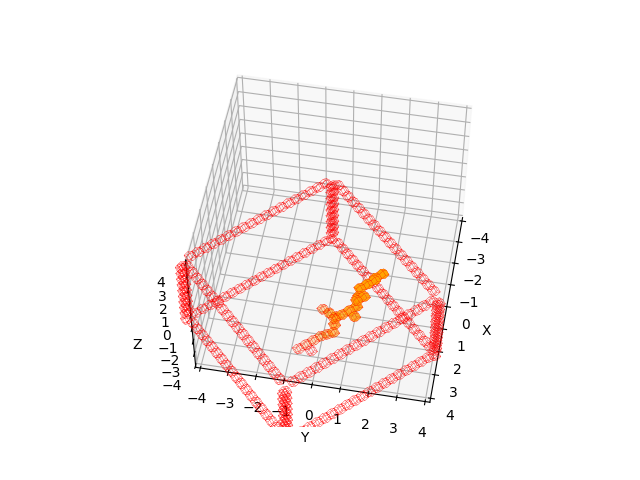

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [ ]:
alphas = list(np.linspace(1, 0, len(RDG_instance_pot.structure_history)))

pos_list = []
#pos_list.extend([(pos[1], pos[2], RDG_instance.dim['width']-pos[0]) for pos in RDG_instance.structure_history])
pos_list.extend([(pos[0], pos[1], RDG_instance_pot.dim['height']-1-pos[2])for pos in RDG_instance_pot.structure_history])
#pos_list.extend([(i, 12, 12) for i in range(20)])



# Plot the edges of the boundary
for x in range(1, RDG_instance_pot.dim['depth']):
    pos_list.append((x, 0, 0)) 
    pos_list.append((x, RDG_instance_pot.dim['height'], 0)) 
    pos_list.append((x, 0, RDG_instance_pot.dim['width']))
    pos_list.append((x, RDG_instance_pot.dim['height'], RDG_instance_pot.dim['width']))
    for _ in range(4):
        alphas.append(0)
        
for y in range(1, RDG_instance_pot.dim['height']):
    pos_list.append((0, y, 0)) 
    pos_list.append((RDG_instance_pot.dim['depth'], y, 0)) 
    pos_list.append((0, y, RDG_instance_pot.dim['width']))
    pos_list.append((RDG_instance_pot.dim['depth'], y, RDG_instance_pot.dim['width']))
    for _ in range(4):
        alphas.append(0)
        
for z in range(1, RDG_instance_pot.dim['width']):
    pos_list.append((0, 0, z))
    pos_list.append((RDG_instance_pot.dim['depth'], 0, z)) 
    pos_list.append((0, RDG_instance_pot.dim['height'], z))
    pos_list.append((RDG_instance_pot.dim['depth'], RDG_instance_pot.dim['height'], z))
    for _ in range(4):
        alphas.append(0)

plot_from_grid(pos_list, alphas=alphas, scale=0.15, line_thickness=0.25)

<IPython.core.display.Javascript object>


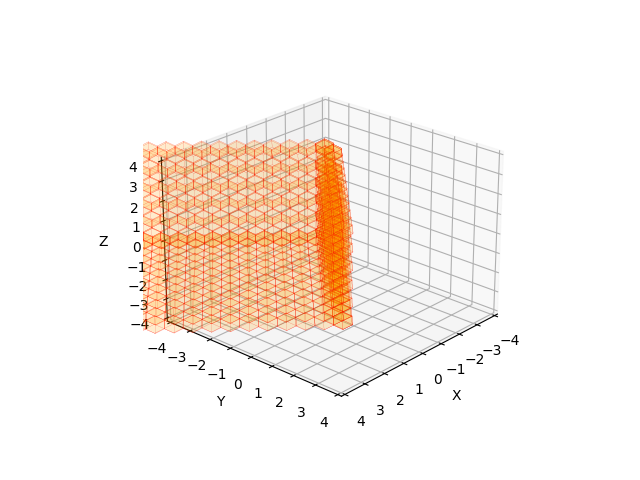

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [10]:
alphas = list(np.linspace(1, 0, len(RDG_instance.structure_history)))

pos_list = []
pos_list.extend([(0,0,i) for i in range(12)])
for x in range(12):
    for y in range(12):
        pos_list.append((x, y, 0)) 
        pos_list.append((x, 0, y)) 
        pos_list.append((0, x, y))
        alphas.append(0)
        alphas.append(0)
        alphas.append(0)

plot_from_grid(pos_list, alphas=alphas, scale=0.3, line_thickness=0.1)

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

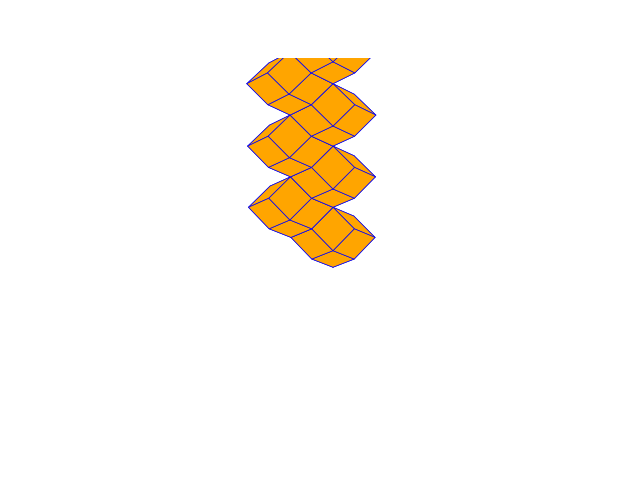

In [25]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i])

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = []
colors = []
alphas = []

pos_list.append((0,0,0))
pos_list.append((0,0,1))
pos_list.append((-1,-1,2))
pos_list.append((-1,-1,3))
pos_list.append((-2,-2,4))
pos_list.append((-2,-2,5))
pos_list.append((-3,-3,6))
pos_list.append((-3,-3,7))
pos_list.append((-4,-4,8))
pos_list.append((-4,-4,9))

for _ in range(len(pos_list)):
    colors.append('orange')
    alphas.append(1)

plot_from_grid(pos_list, colors, alphas)


<IPython.core.display.Javascript object>


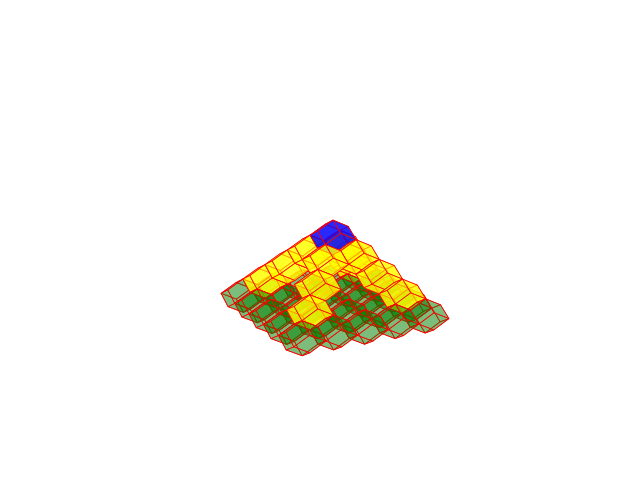

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [19]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas, scale):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i], scale=scale)

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = [(0,0,0)]
for i in range(1,4):
    pos_list.append((0,0,-i))
    pos_list.append((0,i,-i))
    pos_list.append((i,0,-i))
    pos_list.append((i,i,-i))
    

#pos_list.append((0,0,-4))
#pos_list.append((0,4,-4))
#pos_list.append((4,0,-4))
#pos_list.append((4,4,-4))

for x in range(5):
    for y in range(5):
        if (x == 0 or x == 4) and (y == 0 or y == 4) or True:
            pos_list.append((y,x,-4))
        

#(0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
#(0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)
  
colors = ['blue']
colors.extend(['yellow' for _ in range(4*3)])
colors.extend(['green' for _ in range(25)])
alphas = [0.6 for _ in range(4*3+1)]
alphas.extend([0.3 for _ in range(25)])

plot_from_grid(pos_list, colors, alphas, scale=0.6)


<IPython.core.display.Javascript object>


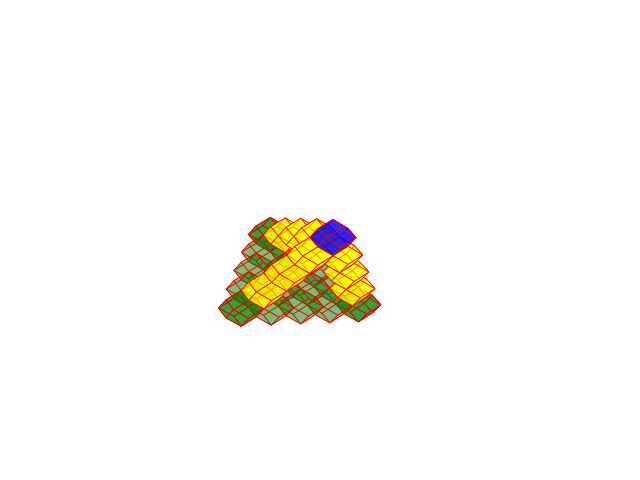

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [62]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas, scale):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i], scale=scale)

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = [(0,0,0)]
pos_list.append((0,0,-1))
pos_list.append((0,-1,0))
pos_list.append((1,0,-1))

for i in range(1,4):
    pos_list.append((0,0,-i))
    pos_list.append((0,-i,0))
    pos_list.append((i,0,-i))
    


for j in range(5):
    for i in range(j, 5):
        pos_list.append((j,-i+j,-4+i-j))
    

#pos_list.append((0,4,-4))
#pos_list.append((4,0,-4))
#pos_list.append((4,4,-4))

        

#(0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
#(0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)
  
colors = ['blue']
colors.extend(['yellow' for _ in range(4*3)])
colors.extend(['green' for _ in range(25)])
alphas = [0.6 for _ in range(4*3+1)]
alphas.extend([0.3 for _ in range(25)])

plot_from_grid(pos_list, colors, alphas, scale=0.6)


[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2)]
[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2), (1, -1, 2)]
[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2), (1, -1, 2), (0, 0, 2)]
[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2), (1, -1, 2), (0, 0, 2), (1, 0, 2)]


<IPython.core.display.Javascript object>


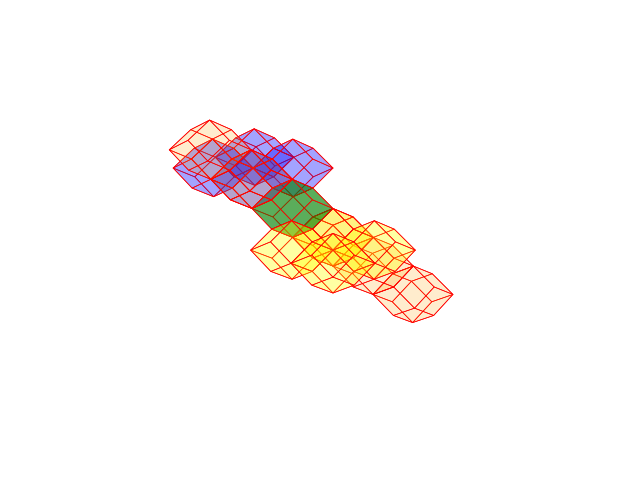

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [12]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i])

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = []
for i in range(5):
    pos_list.append((0,0,i))

for i in range(5):
    pos_list.append((0,i,4))

for i in range(5):
    pos_list.append((i,4,4))

#plot_from_grid(pos_list)

center = (0,0,-3)
pos_list = []
colors = []
alphas = []
for i in range(-2,4):

    pos_list.append((0,0,i))
    if i == 1:
        colors.append('green')
        alphas.append(0.4)
        
        for above_neigh in [(0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1)]:
            pos_list.append((above_neigh[0],above_neigh[1],above_neigh[2]+i))
            print(pos_list)
            colors.append('blue')
            alphas.append(0.2)
            
        for below_neigh in [(0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)]:
            pos_list.append((below_neigh[0],below_neigh[1],below_neigh[2]+i))
            colors.append('yellow')
            alphas.append(0.2)
    else:
        colors.append('orange')
        alphas.append(0.1)
        
#pos_list.append((1,0,0))
#pos_list.append((0,1,0))
#pos_list.append((-1,0,0))
#pos_list.append((0,-1,0))
plot_from_grid(pos_list, colors, alphas)


<IPython.core.display.Javascript object>


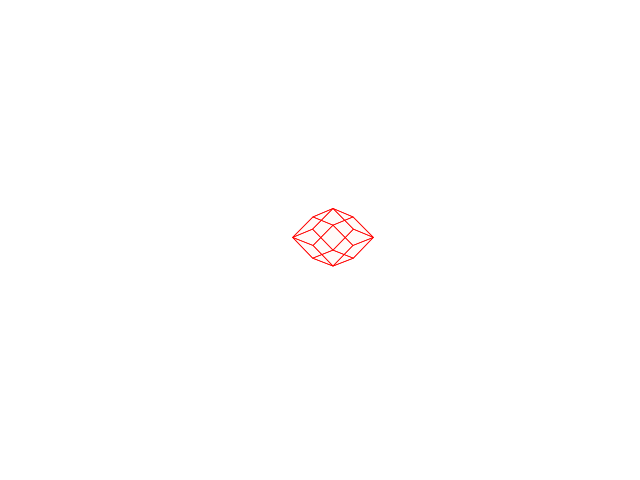

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


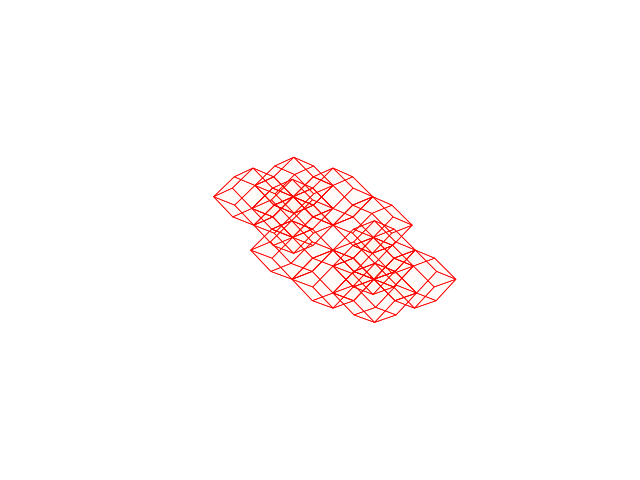

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


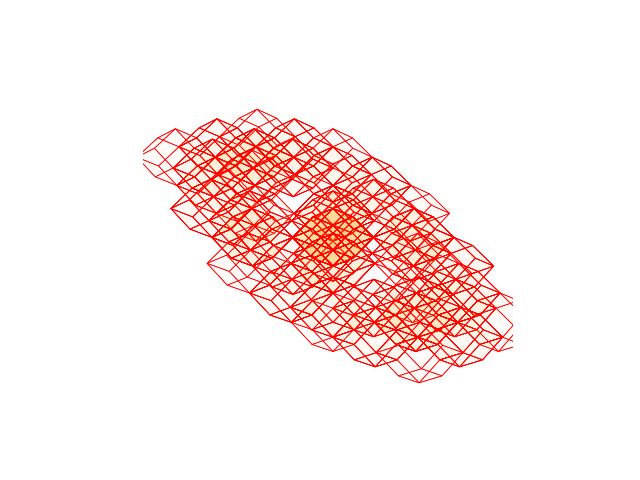

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


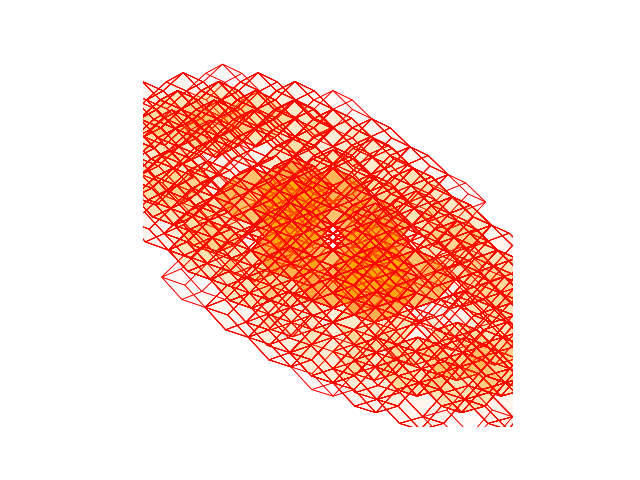

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


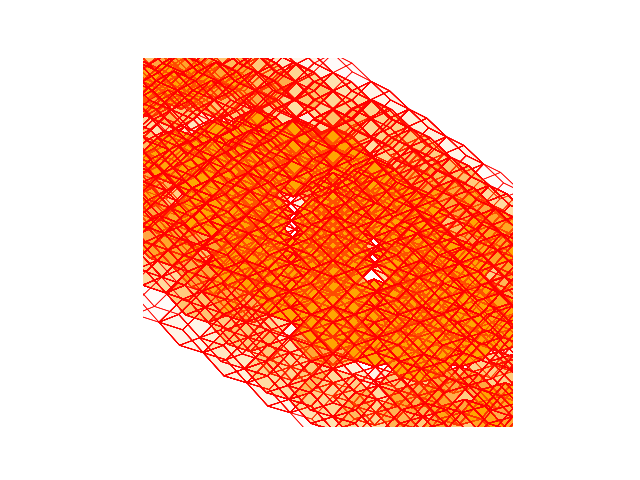

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [13]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i])

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


neighbors = [(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), 
            (0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
            (0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)]

center = (0,0,0)
pos_list = [center]
colors = ['orange']
alphas = [0.01]
plot_from_grid(pos_list, colors, alphas)

for _ in range(4):
    colors = []
    alphas = []
    old_pos_list = []
    old_pos_list.extend(pos_list[:])
    pos_list = []
    for pos in old_pos_list:
        for neighbor in neighbors:
            if (neighbor[0]+pos[0], neighbor[1]+pos[1], neighbor[2]+pos[2]) not in old_pos_list:
                pos_list.append((neighbor[0]+pos[0], neighbor[1]+pos[1], neighbor[2]+pos[2]))
                colors.append('orange')
                alphas.append(0.01)
    plot_from_grid(pos_list, colors, alphas)


In [7]:
import numpy as np
grid = np.zeros((10,10,10))

def directly_up(pos):
    if pos[2] % 2 == 0:
        return (pos[0], pos[1], pos[2]+1)
    else:
        return (pos[0]-1, pos[1]-1, pos[2]+1)

def upwards_neighbors(pos):
    neighbors = []
    if pos[2] % 2 == 0:
        neighbors.append((pos[0], pos[1], pos[2]+1))
        neighbors.append((pos[0]-1, pos[1], pos[2]+1))
        neighbors.append((pos[0], pos[1]-1, pos[2]+1))
        neighbors.append((pos[0]-1, pos[1]-1, pos[2]+1))
    else:
        neighbors.append((pos[0], pos[1], pos[2]+1))
        neighbors.append((pos[0]+1, pos[1], pos[2]+1))
        neighbors.append((pos[0], pos[1]+1, pos[2]+1))
        neighbors.append((pos[0]+1, pos[1]+1, pos[2]+1))
    return neighbors

def below_neighbors(pos):
    neighbors = []
    if pos[2] % 2 == 0:
        neighbors.append((pos[0], pos[1], pos[2]-1))
        neighbors.append((pos[0]-1, pos[1], pos[2]-1))
        neighbors.append((pos[0], pos[1]-1, pos[2]-1))
        neighbors.append((pos[0]-1, pos[1]-1, pos[2]-1))
    else:
        neighbors.append((pos[0], pos[1], pos[2]-1))
        neighbors.append((pos[0]+1, pos[1], pos[2]-1))
        neighbors.append((pos[0], pos[1]+1, pos[2]-1))
        neighbors.append((pos[0]+1, pos[1]+1, pos[2]-1))
    return neighbors
    



# Create subplots for each angle
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')


#plot_rhombic_dodecahedron(ax, pos=(0,0,1), color='green')
#plot_rhombic_dodecahedron(ax, pos=(0,0,-1), color='orange')
#plot_rhombic_dodecahedron(ax, pos=(1,0,0), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(-1,0,0), color='yellow')
plot_rhombic_dodecahedron(ax, pos=(0,2,0), color='orange')

plot_rhombic_dodecahedron(ax, pos=(0,1,0), color='orange')
#plot_rhombic_dodecahedron(ax, pos=(1,1,0), color='white')
#plot_rhombic_dodecahedron(ax, pos=(0,1,1), color='white')
#plot_rhombic_dodecahedron(ax, pos=(1,1,1), color='white')
plot_rhombic_dodecahedron(ax)

#plot_rhombic_dodecahedron(ax, pos=(0,-1,-1), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(-1,-1,0), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(0,-1,0), color='yellow')

#plot_rhombic_dodecahedron(ax, pos=(1,-2,0), color='white')
#plot_rhombic_dodecahedron(ax, pos=(0,-2,1), color='white')
#plot_rhombic_dodecahedron(ax, pos=(1,-2,1), color='white')


plot_rhombic_dodecahedron(ax, pos=(1,0,0), color='pink')
plot_rhombic_dodecahedron(ax, pos=(2,0,0), color='pink')

current_pos = (0,0,1)
for i in range(5):
    if i % 2 == 1:
        alpha = 0
    else:
        alpha = 0.5
    plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos((0,0,i)), color='yellow', alpha=alpha)
    #current_pos = directly_up(current_pos)
    #plot_rhombic_dodecahedron(ax, pos=current_pos, color='yellow')

#this_pos = (0,0,3)
#up_neighbors = upwards_neighbors(this_pos)
#for pos in up_neighbors:
    #plot_rhombic_dodecahedron(ax, pos=pos, color='pink')
    

#plot_rhombic_dodecahedron(ax, pos=(0,0,1), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(0,-1,1), color='yellow', alpha=0.05)
#plot_rhombic_dodecahedron(ax, pos=(-1,0,1), color='yellow', alpha=0.05)
#plot_rhombic_dodecahedron(ax, pos=(-1,-1,1), color='yellow', alpha=0.05)

#plot_rhombic_dodecahedron(ax, pos=(-1,-1,2), color='green')
#plot_rhombic_dodecahedron(ax, pos=(-1,-1,3))

center = (2,2,2)
plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(center), color='yellow')
above = (2,2,2)
plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='red')
#above = (2,3,2)
#plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='pink')
#above = (3,2,2)
#plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='pink')
#above = (3,3,2)
#plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='pink')

up_neighbors = upwards_neighbors(center)
for pos in up_neighbors:
    plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(pos), color='pink')
below_neighbors = below_neighbors(center)
for pos in below_neighbors:
    plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(pos), color='yellow')


plt.show()

<IPython.core.display.Javascript object>

In [29]:

vec_a = np.array([1,1,1])
vec_b = np.array([0,0,2])

print(np.dot(vec_a, vec_b))
print(np.linalg.norm(vec_a))
print(np.linalg.norm(vec_b))
angle = np.arccos(np.dot(vec_a, vec_b)/(np.linalg.norm(vec_a)*np.linalg.norm(vec_b)))
print(angle)

print(np.arccos(2/(2*np.sqrt(3))))
print(np.arccos(1/np.sqrt(3)))

print(0/4 * angle * 180/np.pi)
print(1/4 * angle * 180/np.pi)
print(2/4 * angle * 180/np.pi)
print(3/4 * angle * 180/np.pi)
print(angle * 180/np.pi)


2
1.7320508075688772
2.0
0.9553166181245092
0.9553166181245092
0.9553166181245092
0.0
13.683902579311336
27.367805158622673
41.05170773793401
54.735610317245346
